datetime열에 주어지는 매 시점부터 총 14일(14×24 = 336시간) 분량의 적산차 변화를 예측

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, AveragePooling1D, GlobalAveragePooling1D

In [42]:
train = pd.read_csv("./data_city/data_tr_city.csv")
test = pd.read_csv("./data_city/data_ts_city.csv")
submit = pd.read_csv("./data_city/sample_city.csv")

In [43]:
train = train.fillna(method='bfill')
test = test.fillna(method='bfill')

In [44]:
def normalize(data):
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    return (data - data_mean) / data_std
train['구미 혁신도시배수지 유출유량 적산차'] = normalize(train['구미 혁신도시배수지 유출유량 적산차'])
test['구미 혁신도시배수지 유출유량 적산차'] = normalize(test['구미 혁신도시배수지 유출유량 적산차'])

In [45]:
train = train['구미 혁신도시배수지 유출유량 적산차']
test = test['구미 혁신도시배수지 유출유량 적산차']

In [71]:
def window_dataset_test(x, window_size, batch_size, shuffle):
    ds = tf.data.Dataset.from_tensor_slices(x)
    ds = ds.window(window_size+1, shift=1, drop_remainder=False)
    ds = ds.flat_map(lambda w: w.batch(window_size+1))
    
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [47]:
def windowed_dataset(series, batch_size, past, future, shift=1):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(size=(past + future), shift = shift, drop_remainder = True)
    ds = ds.flat_map(lambda w: w.batch(past + future))
    ds = ds.map(lambda w: (w[:past], w[past:]))
    return ds.batch(batch_size).prefetch(1)

In [48]:
train = train.values
test = test.values

In [49]:
train = train.reshape(-1, 1)
test = test.reshape(-1, 1)

In [12]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# # 스케일을 적용할 column을 정의합니다.
# scaled = scaler.fit_transform(train)
# scaled
# test = scaler.transform(test)

In [52]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(train, train, test_size=0.2, random_state=0, shuffle=False)

In [54]:
batch_size = 336
past = 336*3
future = 336

train_data = windowed_dataset(y_train, batch_size, past, future)
val_data = windowed_dataset(y_val, batch_size, past, future)

In [56]:
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')
    
for data in test_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')
    

데이터셋(X) 구성(batch_size, window_size, feature갯수): (336, 1008, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (336, 336, 1)
데이터셋(X) 구성(batch_size, window_size, feature갯수): (7081, 1008, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (7081, 336, 1)


In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[past, 1]),
    # LSTM
    LSTM(128, activation='tanh'),
    Dense(256, activation="relu"),
    Dense(1),
])

In [59]:
import keras
inputs = keras.layers.Input(shape=(336, 1))
lstm_out = keras.layers.LSTM(128)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
# model.compile(optimizer='adam', loss="mae", metrics = ['mae'])
# model.summary()

In [60]:
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mae'])
# model.compile(optimizer='adam', loss="mae", metrics = ['mae'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 336, 1)]          0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               66560     
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [61]:
history = model.fit(train_data, 
                    validation_data=(val_data), 
                    epochs=1)

80/80 [==============================] - 24s 284ms/step - loss: 0.0115 - mae: 0.0152 - val_loss: 7.5269e-06 - val_mae: 0.0032


In [72]:
test_data = window_dataset_test(test, 336, len(test), None)

: 

: 

In [69]:
pred = model.predict(test_data)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:GPU:0 to /job:localhost/replica:0/task:0/device:CPU:0 in order to run RepeatDataset: stream did not block host until done; was already in an error state [Op:RepeatDataset]

In [ ]:
pred

,datetime,h0,h1,h2,h3,h4,h5,h6,h7,h8,...,h326,h327,h328,h329,h330,h331,h332,h333,h334,h335
1344,2021-02-26 00:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1345,2021-02-26 01:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1346,2021-02-26 02:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1347,2021-02-26 03:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1348,2021-02-26 04:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8420,2021-12-17 20:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8421,2021-12-17 21:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8422,2021-12-17 22:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8423,2021-12-17 23:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
submit[past+future:].iloc[0][1]

0

In [ ]:
for i in pred:
    submit[past+future:].iloc[0][]

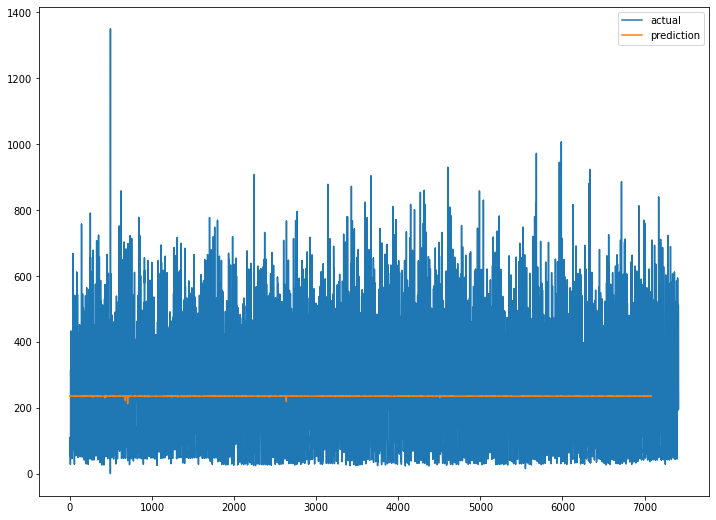

In [ ]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(test)[past:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()